<a href="https://colab.research.google.com/github/SNMS95/ADTO/blob/main/TO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === User-defined Settings for Topology Optimization ===

ML_framework_to_use = "jax"  # Choose ML backend: "torch" or "jax"

# Grid resolution (number of finite elements in x and y directions)
# ⚠️ CNN only supports multiples of 8 for Nx and Ny
Nx = 96                       # Number of elements along x-axis
Ny = 64                       # Number of elements along y-axis

# Material properties
E0 = 1.0                     # Young's modulus of solid material
Emin = 1e-9                  # Young's modulus of void
nu = 0.3                     # Poisson's ratio

# Filter and penalization
rmin = 2.0                   # Radius for density filter
penal = 3.0                  # SIMP penalization factor

# Optimization control
max_iterations = 50         # Number of optimization steps
volfrac = 0.5

# # Sanity checks
# assert ML_framework_to_use in ["jax", "torch"]
assert penal >= 1
assert rmin >= 1

In [2]:
# Check if in Colab and setup accordingly
try:
    import google.colab
    # We're in Colab - clone and setup
    import os
    if not os.path.exists('ADTO'):
        !git clone https://github.com/SNMS95/ADTO.git
    %cd ADTO
    print("🔧 Colab setup complete")
except:
    # We're running locally - no setup needed
    print("🔧 Running locally")

from common_numpy import setup_fea_problem, optimality_criteria, optimality_criteria2
from backend_utils import (compute_compliance_differentiable,
                           apply_density_filter)

🔧 Running locally
Using backend: jax


In [3]:
import jax
import jax.numpy as jnp
print("Training with JAX backend...")

# Setup problem
problem_data = setup_fea_problem(Nx=Nx, Ny=Ny, rmin=rmin, E0=E0, Emin=Emin, penal=penal,
                        nu=nu)
rho_init = jnp.ones((Ny, Nx)) * volfrac  # Initial guess
initial_constr_violation = 0.0

# Create loss function and optimizer

def volume_constraint_fn(rho):
    output = rho.ravel(order='F')
    # Apply filter
    physical_densities = apply_density_filter(output, problem_data)
    constraint = jnp.mean(physical_densities) - volfrac
    return constraint

def obj_and_constraint_fn(rho):
    output = rho.ravel(order='F')
    # Apply filter
    physical_densities = apply_density_filter(output, problem_data)
    # Compute compliance
    compliance, ce = compute_compliance_differentiable(output, problem_data)
    constraint = volume_constraint_fn(rho)
    return (compliance, constraint), (compliance, constraint, physical_densities)

# Training loop
objs = []
constraints = []
designs = []

rho = rho_init
constr_violation = initial_constr_violation

for epoch in range(max_iterations):
    jacobian, aux = jax.jacrev(
        obj_and_constraint_fn, has_aux=True)(rho)
    obj_grads = jacobian[0]
    constraint_grads = jacobian[1]
    rho = optimality_criteria2(
        rho.ravel(), obj_grads.ravel(), constraint_grads.ravel(),
        vol_constr_fn=volume_constraint_fn)
    obj, constr, design = aux
    objs.append(obj)
    constraints.append(constr)
    designs.append(design)
    if epoch % 5 == 0:
        print(f"JAX - Epoch {epoch}, Obj: {obj:.6f}, constr: {constr:.6f}")


Training with JAX backend...
JAX - Epoch 0, Obj: 255.095202, constr: 0.000000
JAX - Epoch 5, Obj: 78.851753, constr: 0.000365
JAX - Epoch 10, Obj: 57.521173, constr: -0.000993
JAX - Epoch 15, Obj: 51.075993, constr: -0.000079
JAX - Epoch 20, Obj: 49.595860, constr: 0.000032
JAX - Epoch 25, Obj: 49.436436, constr: 0.000031
JAX - Epoch 30, Obj: 49.384946, constr: 0.000863
JAX - Epoch 35, Obj: 49.383963, constr: 0.000724
JAX - Epoch 40, Obj: 49.383964, constr: 0.000716
JAX - Epoch 45, Obj: 49.383986, constr: 0.000715


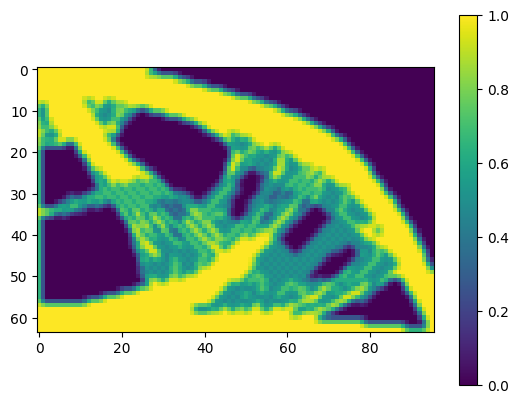

In [4]:
import matplotlib.pyplot as plt
plt.imshow(design.reshape(Ny, Nx, order='F'))
plt.colorbar()

In [ ]:
def run_with_jax_backend():
    """Training example with JAX backend"""
    import jax
    import jax.numpy as jnp
    print("Training with JAX backend...")

    # Setup problem
    problem_data = setup_fea_problem(Nx=Nx, Ny=Ny, rmin=rmin, E0=E0, Emin=Emin, penal=penal,
                            nu=nu)
    rho_init = jnp.ones((Ny, Nx)) * volfrac  # Initial guess
    initial_constr_violation = 0.0

    # Create loss function and optimizer
    def obj_and_constraint_fn(rho):
        output = rho.ravel(order='F')
        # Apply filter
        physical_densities = apply_density_filter(output, problem_data)
        # Compute compliance
        compliance, ce = compute_compliance_differentiable(output, problem_data)
        constraint = jnp.mean(physical_densities)
        return (compliance, constraint), (compliance, constraint, physical_densities)

    # Training loop
    objs = []
    constraints = []
    designs = []

    rho = rho_init
    constr_violation = initial_constr_violation

    for epoch in range(max_iterations):
        jacobian, aux = jax.jacrev(
            obj_and_constraint_fn, has_aux=True)(rho)
        obj_grads = jacobian[0]
        constraint_grads = jacobian[1]
        rho, constr_violation = optimality_criteria(rho.ravel(), obj_grads.ravel(), constraint_grads.ravel(), constr_violation)
        obj, constr, design = aux
        objs.append(obj)
        constraints.append(constr)
        designs.append(design)
        if epoch % 5 == 0:
            print(f"JAX - Epoch {epoch}, Obj: {obj:.6f}, constr violation: {constr_violation:.6f}")
    return objs, constraints, designs

def run_with_pytorch_backend():
    """Training example with PyTorch backend"""
    import torch
    print("Training with PyTorch backend...")

    # Setup problem
    problem_data = setup_fea_problem(Nx=Nx, Ny=Ny, rmin=rmin, E0=E0, Emin=Emin, penal=penal,
                           nu=nu)
    # Create nn model
    model, model_input = create_network_and_input(nn_type=nn_type, hyper_params=nn_arch_details,
                                   random_seed=random_seed, grid_size=(Ny, Nx))

    # Setup optimizer
    optimizer = get_optimizer(optimizer_str, **optimizer_hyper_params)

    # Training loop
    for epoch in range(max_iterations):
        with torch.enable_grad():
            # Forward pass
            densities = model(model_input)
            densities = volume_enforcing_filter(densities, volfrac)
            filtered_densities = apply_density_filter(densities, problem_data)

            # Physics simulation
            compliance, _ = compute_compliance_differentiable(filtered_densities.flatten(), problem_data)
            # Backward pass
            model.zero_grad()
            trainable_weights = [v for v in model.trainable_weights]

            # Call torch.Tensor.backward() on the loss to compute gradients
            # for the weights.
            compliance.backward()
            gradients = [v.value.grad for v in trainable_weights]

            # Update weights
            with torch.no_grad():
                optimizer.apply(gradients, trainable_weights)

        if epoch % 10 == 0:
            print(f"PyTorch - Epoch {epoch}, Loss: {compliance.item():.6f}")

    return compliance.item()

def train_nn_model():
    """Train the neural network model."""
    backend = keras.backend.backend()
    if backend == "jax":
        return train_with_jax_backend()
    elif backend == "pytorch":
        return train_with_pytorch_backend()
    else:
        raise ValueError(f"Unknown backend: {backend}")

AD_in_TO.ipynb	fea_bisec_numpy.py  LICENSE	 README.md
custom_vjps.py	jax		    __pycache__
